# <font color= #99C8F5> **ARIMA Models** </font>

_by Isabel Valladolid, Sofía Maldonado, Vivienne Toledo, & Aissa Gonzalez

15/02/2026.

This project will cover the **_Real Median Household Income_** indicator from the Federal Reserve Bank of St. Louis (FRED).

# <font color= #99C8F5> **Libraries & Data** </font>

In [6]:
# General
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import os

# Data
from fredapi import Fred

# Visualization
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

# Preprocessing
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Models
from statsmodels.tsa.arima.model import ARIMA

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Configuración de gráficos
plt.style.use('ggplot')

In [10]:
# Get the API KEY
load_dotenv()
FRED_API_KEY = os.getenv('FRED_API_KEY')

# <font color= #99C8F5> **Visualization** </font>

In [11]:
try:
    fred = Fred(api_key=FRED_API_KEY)

    # Usaremos 'MEHOINUSA672N': Real Median Household Income 
    series_id = 'MEHOINUSA672N'
    df = pd.DataFrame(fred.get_series(series_id), columns=['value'])
    df.index.name = 'date'

    # IMPORTANTE: Establecemos la frecuencia explícita (Mensual - Inicio)
    df.index = pd.DatetimeIndex(df.index).to_period('M').to_timestamp()
    df.index.freq = 'MS'

except Exception as e:
    print(f"Error: {e}")

fig = px.line(df, x=df.index, y='value', title=f'Time Series: {series_id}')
fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Index',

)
fig.show()

Error: Inferred frequency AS-JAN from passed values does not conform to passed frequency MS


In [13]:
# Checando si la serie es estacionaria
val_dickey_fuller = adfuller(df['value'])
kpss_test = kpss(df['value'])
print(f"Dickey-Fuller: {val_dickey_fuller[1]}")
print(f"KPSS: {kpss_test[1]}")

Dickey-Fuller: 0.9792411831307773
KPSS: 0.01


C:\Users\Aissa\AppData\Local\Temp\ipykernel_16124\1357428908.py:3: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




No es estacionaria :(

In [14]:
df['diff_1'] = df['value'].diff()

In [15]:
fig = px.line(df, x=df.index, y='diff_1', title=f'Time Series, 1 Differentiation: {series_id}')
fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Index',
)
fig.show()

Todavía no es estacionaria, de nuevo...

In [16]:
df['diff_2'] = df['diff_1'].diff()

In [17]:
fig = px.line(df, x=df.index, y='diff_2', title=f'Time Series, 2 Differentiations: {series_id}')
fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Index',
)
fig.show()

In [18]:
# Checando si la serie diferenciada es estacionaria
val_dickey_fuller = adfuller(df['diff_2'].dropna())
kpss_test = kpss(df['diff_2'].dropna())
print(f"Dickey-Fuller: {val_dickey_fuller[1]}")
print(f"KPSS: {kpss_test[1]}")

Dickey-Fuller: 0.00028648655228870107
KPSS: 0.1


C:\Users\Aissa\AppData\Local\Temp\ipykernel_16124\150815335.py:3: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




## Identificación de Órdenes (p, q)

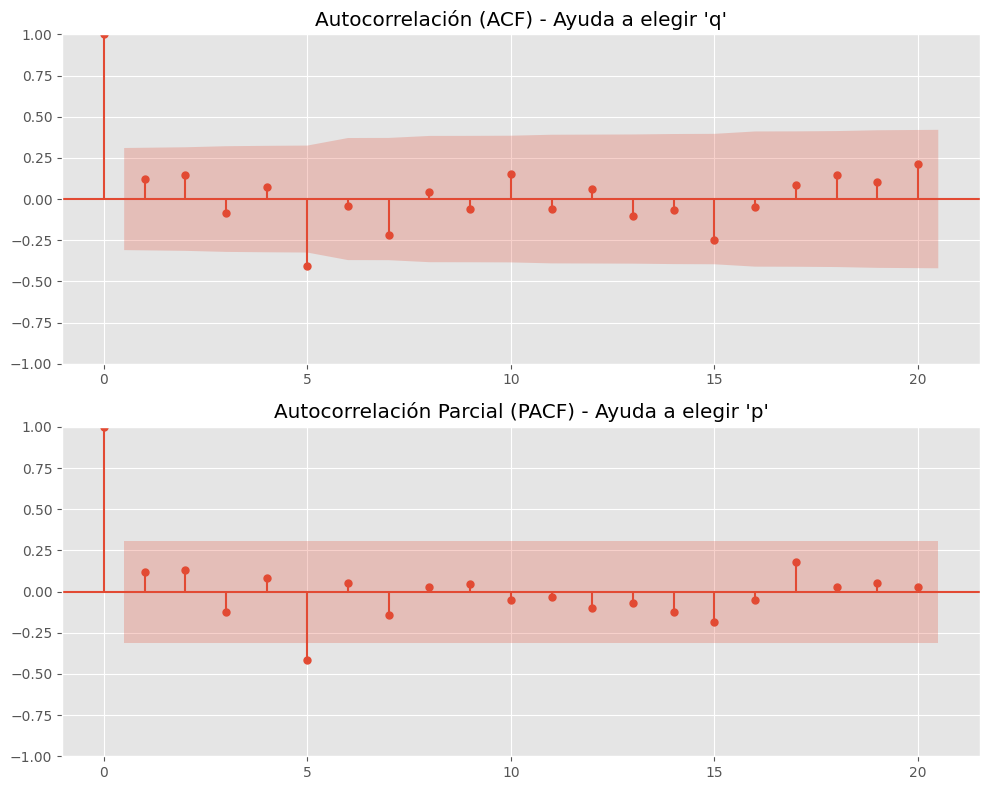

In [19]:
series_analysis = df['diff_1'].dropna()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Graficamos ACF (para q)
plot_acf(series_analysis, lags=20, ax=ax1, title="Autocorrelación (ACF) - Ayuda a elegir 'q'")

# Graficamos PACF (para p)
plot_pacf(series_analysis, lags=20, ax=ax2, title="Autocorrelación Parcial (PACF) - Ayuda a elegir 'p'")

plt.tight_layout()
plt.show()

In [25]:
# modelo ARIMA


# Definimos el tamaño del test
test_size = 6

# Separamos los datos
train = df.iloc[:-test_size]
test = df.iloc[-test_size:]


# Ajustamos el modelo ARIMA
# Nota: Statsmodels maneja la diferenciación (d=1) internamente.
model = ARIMA(train['value'], order=(1, 1, 5))
results = model.fit()
print(results.summary())

# Realizamos el pronóstico para los pasos del Test set
# start: índice donde empieza el test, end: índice donde termina
forecast_object = results.get_forecast(steps=len(test))
forecast = forecast_object.predicted_mean
conf_int = forecast_object.conf_int(alpha=0.05) # 95% confianza

# Convertimos a DataFrame para facilitar el manejo
forecast_df = pd.DataFrame({
    'date': test.index,
    'actual': test['value'],
    'forecast': forecast.values,
    'lower_ci': conf_int.iloc[:, 0].values,
    'upper_ci': conf_int.iloc[:, 1].values
})
forecast_df.set_index('date', inplace=True)

# Cálculo de Métricas de Error
rmse = np.sqrt(mean_squared_error(test['value'], forecast))
mae = mean_absolute_error(test['value'], forecast)
print(f"\n--- Métricas de Evaluación en Test Set ---")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")


fig = go.Figure()
# Datos de Entrenamiento (Histórico)
# Mostramos solo los últimos años para que se vea bien el detalle del final
train_subset = train[train.index > '2018-01-01']

fig.add_trace(go.Scatter(
    x=train_subset.index, y=train_subset['value'],
    mode='lines', name='Train',
    line=dict(color='gray')
))

# Datos Reales (Test)
fig.add_trace(go.Scatter(
    x=test.index, y=test['value'],
    mode='lines+markers', name='Test',
    line=dict(color='green', width=2)
))

# Pronóstico del Modelo
fig.add_trace(go.Scatter(
    x=forecast_df.index, y=forecast_df['forecast'],
    mode='lines+markers', name='ARIMA',
    line=dict(color='red', dash='dash', width=2)
))

# Intervalos de Confianza
fig.add_trace(go.Scatter(
    x=forecast_df.index.tolist() + forecast_df.index[::-1].tolist(),
    y=forecast_df['upper_ci'].tolist() + forecast_df['lower_ci'][::-1].tolist(),
    fill='toself',
    fillcolor='rgba(255, 0, 0, 0.15)',
    line=dict(color='rgba(255,255,255,0)'),
    name='Intervalo de Confianza (95%)',
    hoverinfo="skip"
))

fig.update_layout(
    title='Real vs Forecast',
    xaxis_title='Fecha',
    yaxis_title='Indice',
    hovermode="x unified",
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01)
)

fig.show()

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   35
Model:                 ARIMA(1, 1, 5)   Log Likelihood                -293.934
Date:                Sun, 15 Feb 2026   AIC                            601.867
Time:                        14:51:44   BIC                            612.552
Sample:                    01-01-1984   HQIC                           605.511
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1669      2.083     -0.080      0.936      -4.250       3.916
ma.L1          0.2069      2.084      0.099      0.921      -3.878       4.291
ma.L2          0.0774      0.123      0.629      0.5